In [1]:
%run setup.py
import tqdm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import lightkurve

In [3]:
# koi = pd.read_csv('../data/koi.csv')
toi = pd.read_csv('../data/toi.csv')

In [4]:
from astropy.stats import BoxLeastSquares

def high_pass(t, y, width=3.):
    y_low = gaussian_filter(y, width)
    return y - y_low

def get_kepler_lc(kic_id):
    file = glob.glob(f'../data/lightcurves/Kepler/*{kic_id}.txt')[0]
    t, y = np.loadtxt(file, usecols=(0,1)).T
    return t, y
    
def preprocess_lc(t, y):
    y = high_pass(t, y)
    lc = lk.LightCurve(t, y).remove_outliers()
    return lc.time, lc.flux

In [4]:
toi_dsct = toi[toi['dsct'] == True].sort_values('Period (days)', ascending=False)
toi_dsct[['TIC ID', 'Period (days)']]

,TIC ID,Period (days)
395,309402106,216.244995
565,372913430,13.477940
470,295599256,7.143860
519,120269103,6.597550
461,255704097,6.015240
459,202563254,4.473330
477,80275202,3.664650
474,89759617,3.330410
452,156987351,3.062959
488,409934330,2.488964


In [46]:
import lightkurve as lk

# lc = lk.TessLightCurveFile('../data/lightcurves/TESS/372913430.fits').FLUX.remove_nans()
# t, y = lc.time, lc.flux
t, y = np.loadtxt('../data/lightcurves/eleanor/372913430.csv', usecols=(0,1)).T
t, y = preprocess_lc(t, y)
t = np.asarray(t, dtype='float64')
y = np.asarray(y, dtype='float64')

In [5]:
import lightkurve as lk

lc = lk.search_lightcurvefile('TOI 2143', mission='TESS').download_all().stitch().remove_nans()
t, y = lc.time, lc.flux
t = np.asarray(t, dtype='float64')
y = np.asarray(y, dtype='float64')

/Users/daniel/anaconda3/envs/maelstrom/lib/python3.6/site-packages/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicitely using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


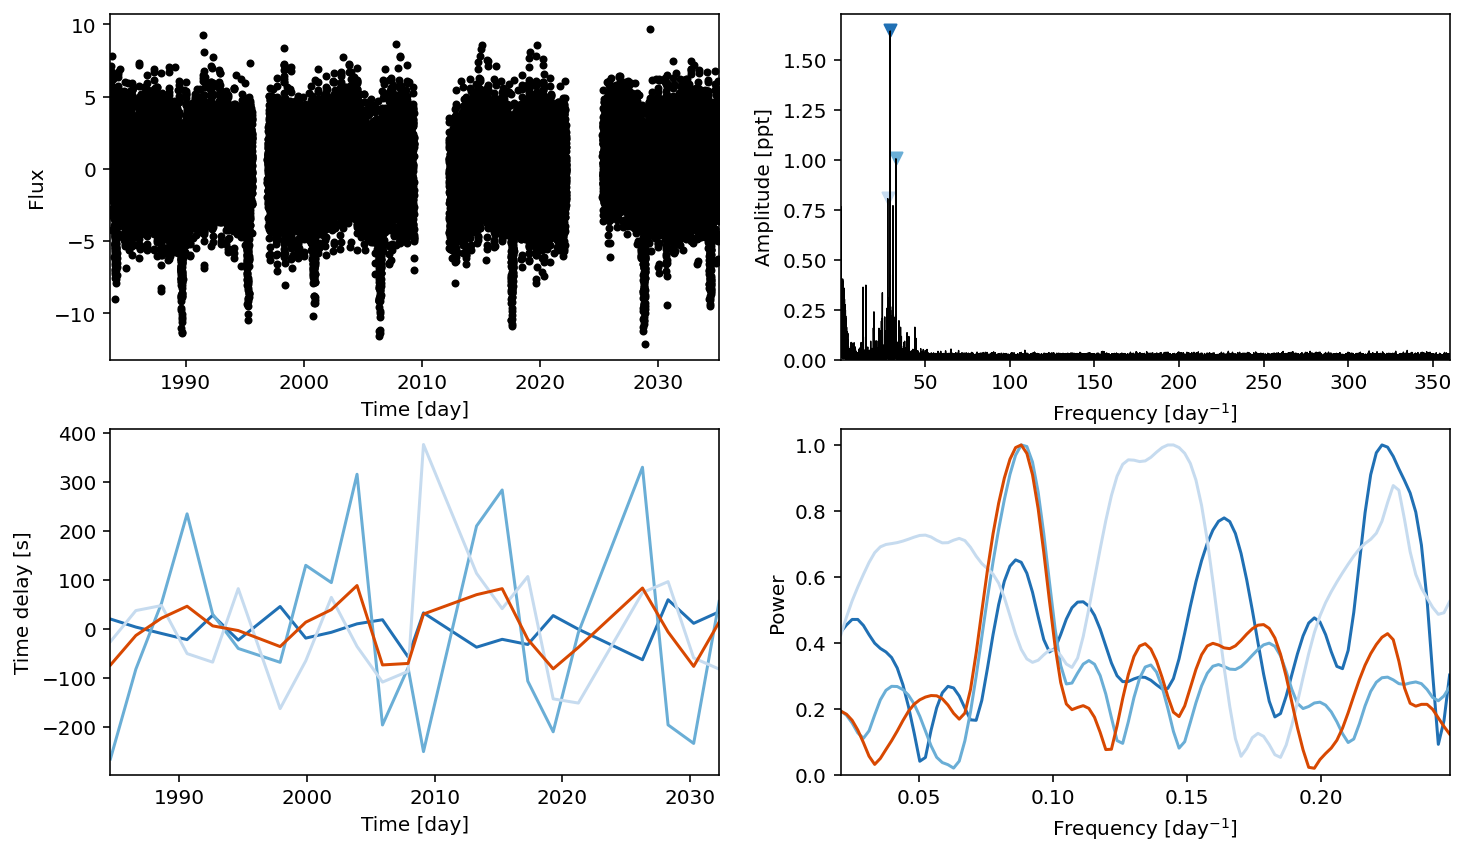

In [7]:
ms = Maelstrom(t, y, fmin=20, fmax=40, max_peaks=3)
ax = ms.first_look(segment_size=2);
# ax[1].set_xlim(0,30)
# ax[3].axvline(1./koi_period, c='g', linestyle='dashed')

In [8]:
ms.freq

array([29.19614335, 32.56721083, 27.74162933])

In [9]:
time, flux = ms.time, ms.flux
freq, weight = ms.freq, ms.get_weights(norm=False)

In [12]:
pg = ms.period_search()

In [19]:
periods = [5.589479]
periods = np.linspace(1, 10, 50)
res = pg.fit(periods)

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


In [14]:
res

[[(-107166.83779510476,
   {'period': array(5.589479),
    'nu': array(29.19614335),
    'phi_angle__': array([ 4.22433761, -1.4679822 ]),
    'logasini_interval__': array(-0.56043779),
    'drift': array(-8.04313735e-07),
    'phi': array(1.9052475),
    'logasini': array(2.51059719),
    'w': array([-6.18335415e-01,  1.52880635e+00,  1.05580305e-03]),
    'phase': array(1.95513846)})],
 [(-120356.62227044112,
   {'period': array(5.589479),
    'nu': array(32.56721083),
    'phi_angle__': array([ 2.44805435, -3.74259889]),
    'logasini_interval__': array(0.33735752),
    'drift': array(-1.05926012e-06),
    'phi': array(2.56233676),
    'logasini': array(4.03101017),
    'w': array([ 8.65833470e-01, -5.28354868e-01, -4.70947473e-04]),
    'phase': array(-0.54790536)})],
 [(-123273.05936214938,
   {'period': array(5.589479),
    'nu': array(27.74162933),
    'phi_angle__': array([ 1.01498925, -4.3554338 ]),
    'logasini_interval__': array(0.10672367),
    'drift': array(1.00817405e-0

In [15]:
np.exp(2.51059719)

12.312280636319974

In [18]:
from maelstrom.utils import mass_function
import astropy.units as u

mf = mass_function(5.589479*u.day, 12.312280636319974 * u.s)
mass = (mf.to(u.M_jup))**(1/3) * ((1.6*u.M_sun).to(u.M_jup))**(2/3)
mass.to(u.M_sun)

<Quantity 0.5476022 solMass>

In [58]:
(16.234722 * u.R_earth).to(u.R_sun) / (1.6 * u.R_sun)


<Quantity 0.09302383>

In [44]:
np.exp(3.45885038)

31.780420099146262

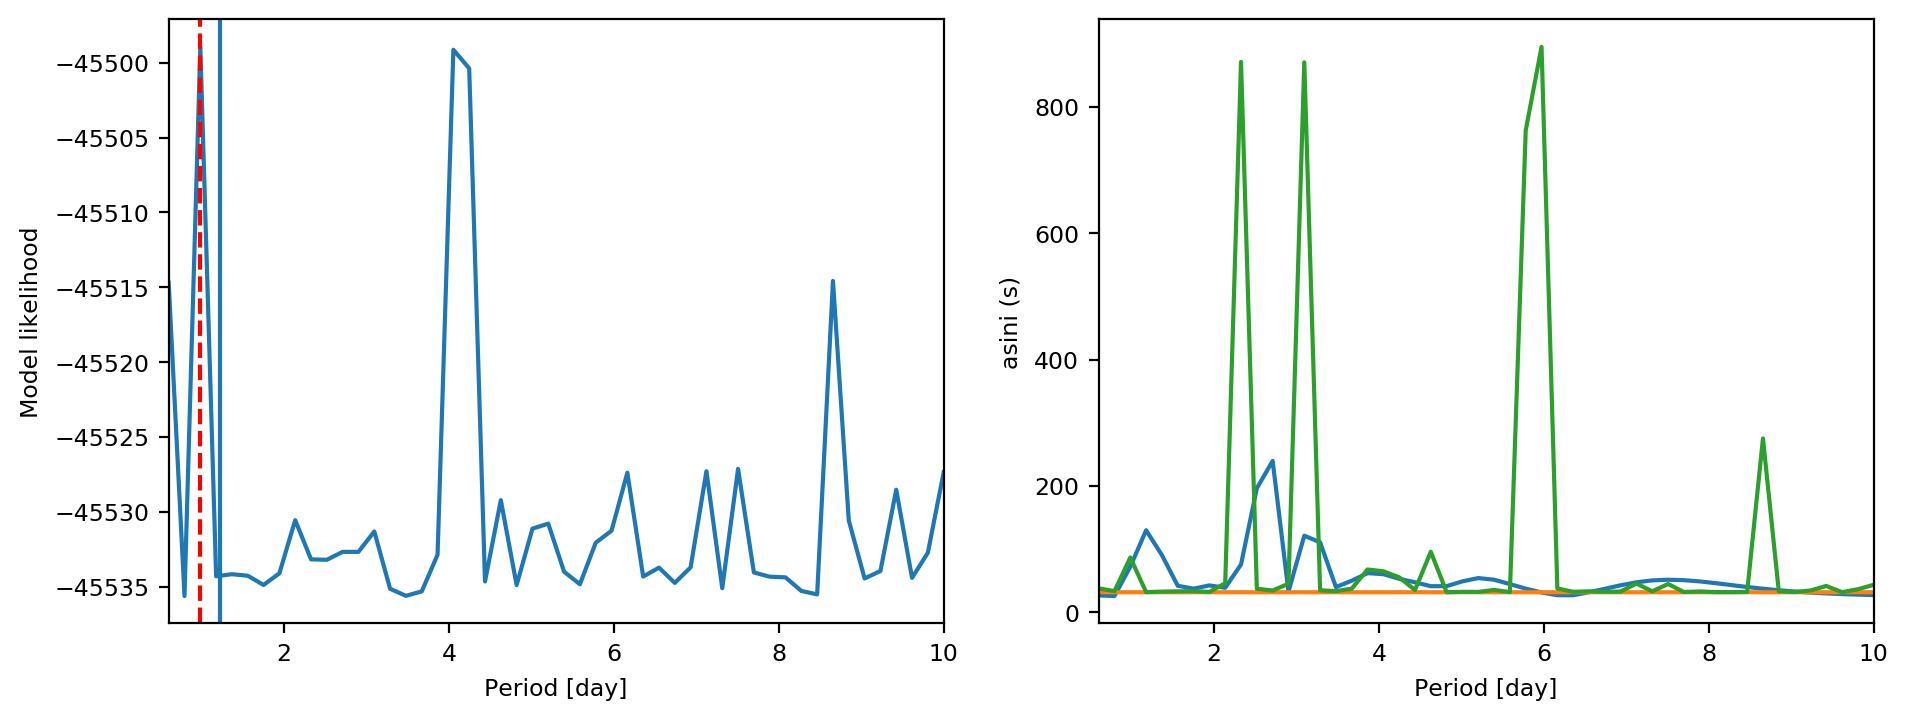

In [26]:
ax = pg.diagnose()

ax[0].axvline(1.219868)

In [16]:
from maelstrom.utils import mass_function
import astropy.units as u

mf = mass_function(1.21*u.day, 31.774026204097503 * u.s)
mass = (mf.to(u.M_jup))**(1/3) * ((1.6*u.M_sun).to(u.M_jup))**(2/3)
mass.to(u.M_sun)

<Quantity 3.91973072 solMass>

In [29]:
mass.to(u.M_sun)

<Quantity 3.91973072 solMass>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12fd45f50>,
      dtype=object)

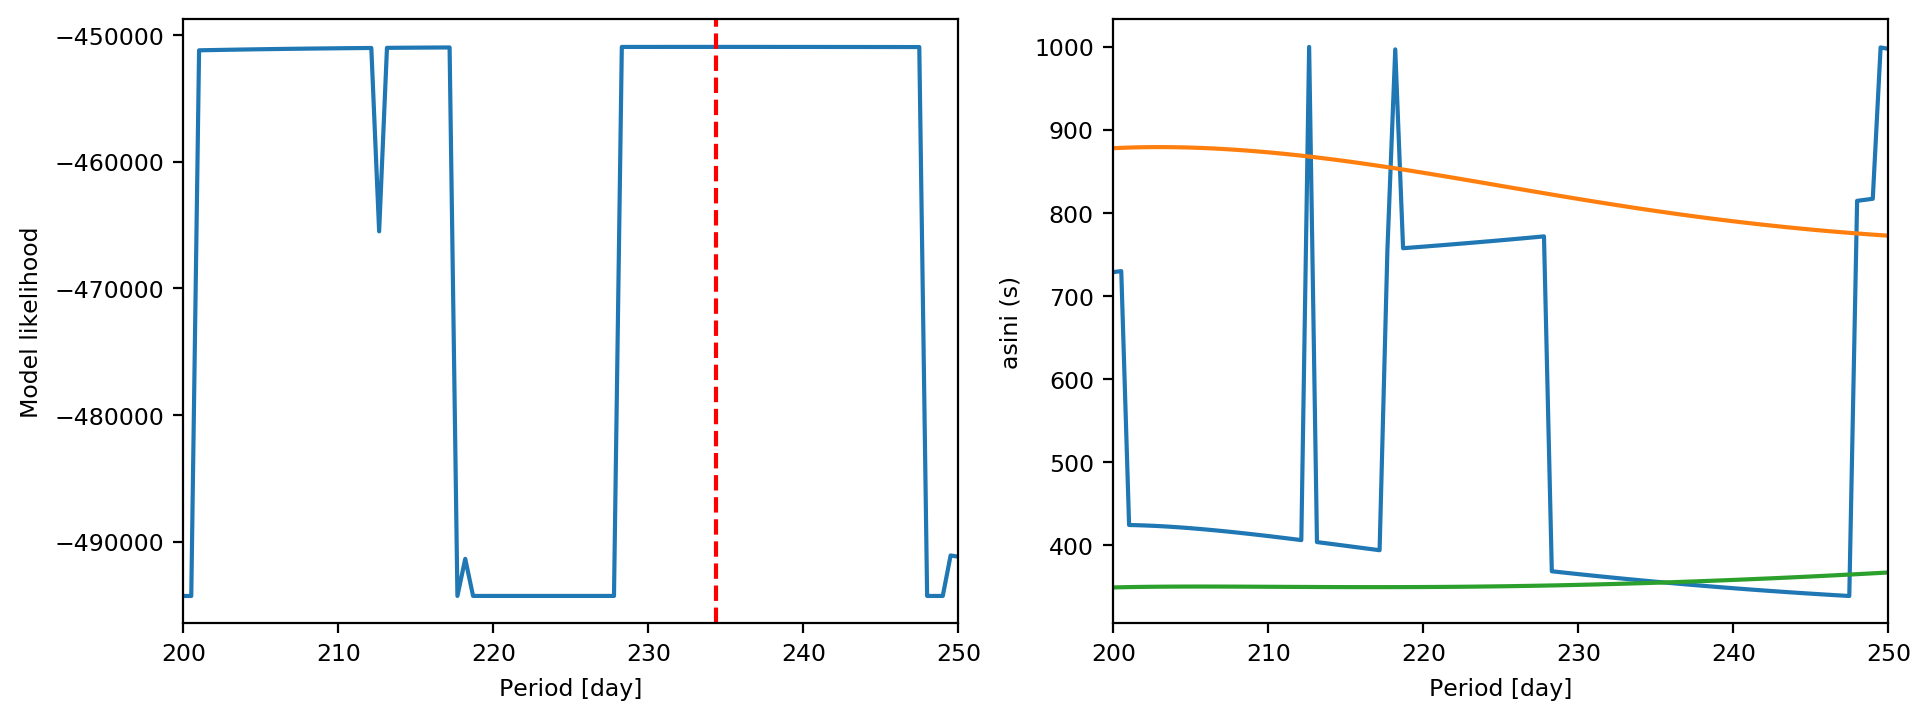

In [11]:
flux = (flux / 1e3) + 1

In [12]:
time += 2457000

In [20]:
flat_flux = lc.flatten().flux

In [14]:
midtime = time[np.argmin(flux)]

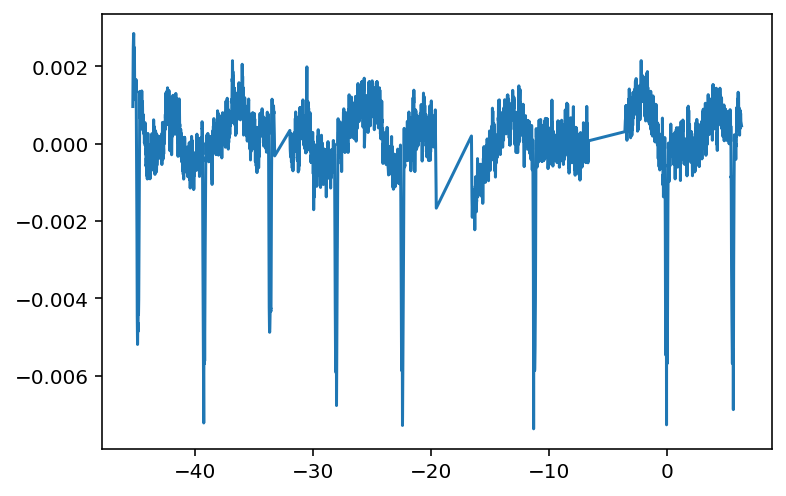

In [21]:
plt.plot(time - midtime, flux - flat_flux)
# plt.axvline(2459012.016018)

(2459027.849023855, 2459029.849023855)

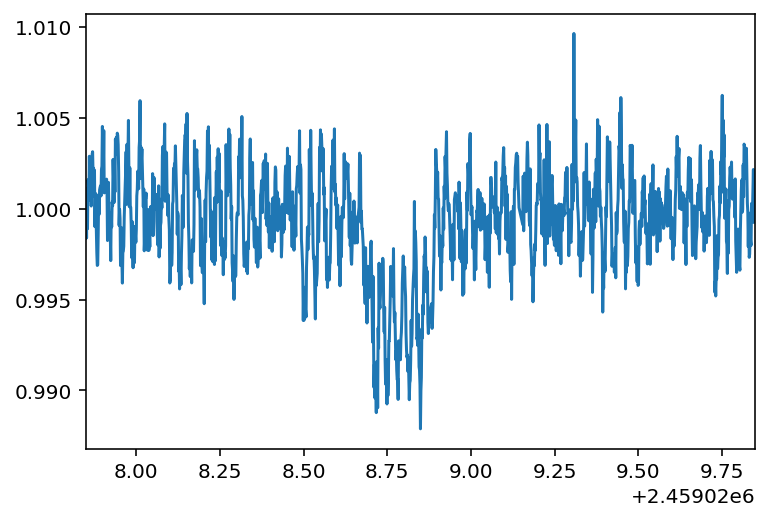

In [18]:
plt.plot(time, flux)
plt.xlim(midtime-1, midtime+1)

In [22]:
np.savetxt('TOI2143.txt', list(zip(time - midtime, flux - flat_flux, lc.flux_err)))

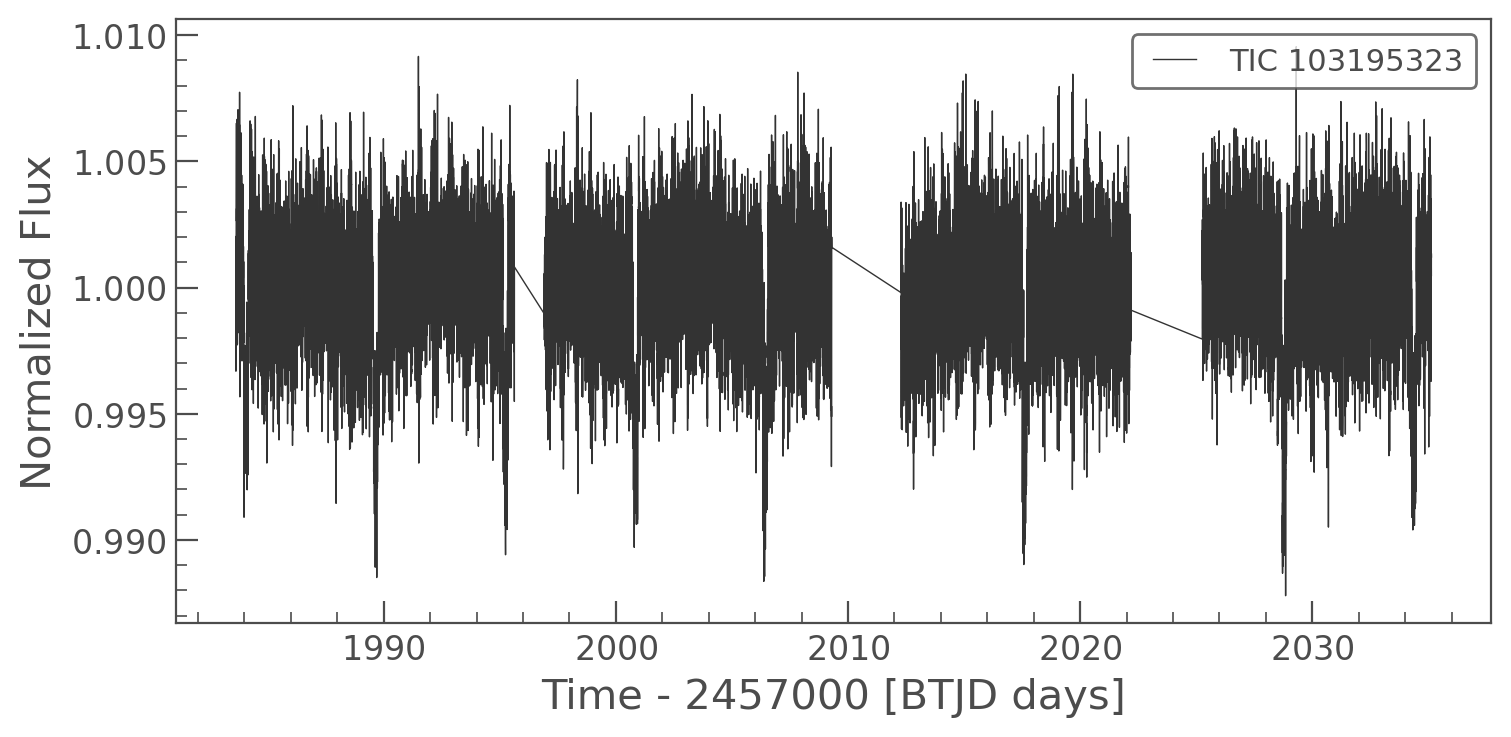

In [25]:
lc.plot()

In [34]:
from astroquery.mast import Observations, Catalogs

result = Catalogs.query_criteria(catalog="Tic", ID=103195323).to_pandas()


/Users/daniel/anaconda3/envs/maelstrom/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/daniel/anaconda3/envs/maelstrom/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
result

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,103195323,20190415,NaN,4510-00152-1,826-007601,04101752+7510152,NaN,J041017.52+751015.3,549998638456973184,60779836,...,NaN,0.756104,0.628545,62.572982,75.170931,0.021598,0.019546,1,0,57198335


In [55]:
result.dec

0    75.170901
Name: dec, dtype: float64

In [37]:
for col in result.columns:
    print(col)

ID
version
HIP
TYC
UCAC
TWOMASS
SDSS
ALLWISE
GAIA
APASS
KIC
objType
typeSrc
ra
dec
POSflag
pmRA
e_pmRA
pmDEC
e_pmDEC
PMflag
plx
e_plx
PARflag
gallong
gallat
eclong
eclat
Bmag
e_Bmag
Vmag
e_Vmag
umag
e_umag
gmag
e_gmag
rmag
e_rmag
imag
e_imag
zmag
e_zmag
Jmag
e_Jmag
Hmag
e_Hmag
Kmag
e_Kmag
TWOMflag
prox
w1mag
e_w1mag
w2mag
e_w2mag
w3mag
e_w3mag
w4mag
e_w4mag
GAIAmag
e_GAIAmag
Tmag
e_Tmag
TESSflag
SPFlag
Teff
e_Teff
logg
e_logg
MH
e_MH
rad
e_rad
mass
e_mass
rho
e_rho
lumclass
lum
e_lum
d
e_d
ebv
e_ebv
numcont
contratio
disposition
duplicate_id
priority
eneg_EBV
epos_EBV
EBVflag
eneg_Mass
epos_Mass
eneg_Rad
epos_Rad
eneg_rho
epos_rho
eneg_logg
epos_logg
eneg_lum
epos_lum
eneg_dist
epos_dist
distflag
eneg_Teff
epos_Teff
TeffFlag
gaiabp
e_gaiabp
gaiarp
e_gaiarp
gaiaqflag
starchareFlag
VmagFlag
BmagFlag
splists
e_RA
e_Dec
RA_orig
Dec_orig
e_RA_orig
e_Dec_orig
raddflag
wdflag
objID
